In [1]:
"""
广发证券-行为金融研究系列之六：A股羊群效应投资策略研究-201102
Beta方法
"""
import pandas as pd
import numpy as np
import akshare as ak
import statsmodels.formula.api as smf
import datetime
import math
import matplotlib.pyplot as plt


class Herd_Effect(object):
    def __init__(self, params_grids):
        self.cash = params_grids['cash']
        self.capacity = params_grids['capacity']
        self.sector_code_list = ak.sw_index_spot()['指数代码']

        self.x = 3
        self.N = 4
        self.V = 0.5
        self.Z = 0.07
        self.M = 5
        self.Y = 0.13
        self.sector_beta_std = pd.read_csv('D:/Python/Flies/Guanyun/A股数据/Herd_Data/Stock_beta/Beta_Std_of_Sector.csv')
        self.sector_beta_mean = pd.read_csv('D:/Python/Flies/Guanyun/A股数据/Herd_Data/Stock_beta/Beta_Mean_of_Sector.csv')
        self.sector_pctchange = pd.read_csv('D:/Python/Flies/Guanyun/A股数据/Herd_Data/Stock_beta/sector_weekly_pctchange.csv')
        self.all_stock_price_data = pd.read_csv('D:/Python/Flies/Guanyun/A股数据/Herd_Data/Stock-Daily-Close-XXXXXX.csv',dtype=str)
        self.stock_weekly_chg = pd.read_csv('D:/Python/Flies/Guanyun/A股数据/Herd_Data/Stock-Weekly-Change.csv')
        self.sector_beta_std.set_index('date', inplace=True)
        self.sector_beta_mean.set_index('date', inplace=True)
        self.sector_pctchange.set_index(['date'], inplace=True)
        self.all_stock_price_data.set_index(['date'], inplace=True)
        self.stock_weekly_chg.set_index(['date'], inplace=True)

    def Herd_Beta(self, date_now):
        """
        给定date，选出羊群行业
        """
        sector_x_list = [sector \
                             for sector in self.sector_pctchange.columns \
                                 if self.sector_pctchange[self.sector_pctchange.index == date_now][sector].values[0] <= self.x]  # 过滤涨幅超x%的行业
        sector_beta_list = self.sector_beta_std.loc[date_now, sector_x_list]  # 只考虑涨幅未超过x%的行业
        return sector_beta_list[sector_beta_list.nsmallest(self.N).index.values]  # 选出这些行业中β前N小的行业

    def Leading_Testing(self, sector_code, date_now):
        """
        对sector下所有成分股筛选龙头股
        """
        stock_list = pd.read_csv('D:\\Python\\Flies\\Guanyun\\A股数据\\申万一级行业成份\\' + sector_code +'.csv',dtype=str)
        for stock in stock_list['stock_code']:
            try:
                if self.stock_weekly_chg.loc[date_now, stock] > self.Y:
                    return 1
            except:
                print(stock, 'has no data in date:', date_now)  # 当前区间股票尚未发售等原因，无法提取数据
        return 0

    def Choose_Stock(self, sector, date_now, herd_sector_beta):
        beta_lower_V_stock = pd.DataFrame(
            columns=['stock', 'deviation', 'weekly_chg'])
        stock_beta_data = pd.read_excel('D:/Python/Flies/Guanyun/A股数据/Herd_Data/Stock_beta/Beta_of_Stock.xlsx',\
                                        sheet_name = sector).set_index('Date').loc[date_now]

        for stock in stock_beta_data.index:
            deviation = abs(stock_beta_data[stock] - herd_sector_beta
                            ) / herd_sector_beta  # 计算偏离度，之后会对各股偏离度排序
            stock = stock[:6]  # stock形式从 000001.SH 转为 000001
            weekly_chg = self.stock_weekly_chg.loc[date_now,
                                                   stock]  # 计算周涨幅，周涨幅小于Z
            beta_lower_V_stock = beta_lower_V_stock.append(
                [{
                    'stock': stock,
                    'deviation': deviation,
                    'weekly_chg': weekly_chg
                }],
                ignore_index=True)

        beta_lower_V_stock = beta_lower_V_stock.sort_values(by="deviation")
        beta_lower_V_stock = beta_lower_V_stock.loc[:int(len(beta_lower_V_stock) * self.V), :]  # 选择偏离度最小的 100*V% 的stock
        beta_lower_V_stock = beta_lower_V_stock[beta_lower_V_stock['weekly_chg'] < self.Z]  # 选择涨幅不超过Z的
        #         beta_lower_V_stock = beta_lower_V_stock[abs(beta_lower_V_stock['weekly_chg']) < self.Z]  # 选择涨幅不超过Z的

        if len(beta_lower_V_stock) <= self.M:  # 每个行业选择不超过M只股票 （ 这里，若多余M只，我选择偏离度最小的M只股票 ）
            return beta_lower_V_stock
        else:
            return beta_lower_V_stock[:self.M]

    def close_today(self, stock, date_now, method='next'):
        """
        默认获取最近一个交易日的close,stock为sh/sz+XXXXXX，method = next 时获取下一交易日的close
        """
        if method == 'lastest':
            day_1_stock = self.all_stock_price_data[(self.all_stock_price_data.index <=date_now)][stock].sort_index()
            day_1_stock = day_1_stock.dropna(how='any')
            return float(day_1_stock.iloc[-1])
        elif method == 'next':
            day_1_stock = self.all_stock_price_data[(self.all_stock_price_data.index >=date_now)][stock].sort_index()
            day_1_stock = day_1_stock.dropna(how='any')
            return float(day_1_stock.iloc[0])

    def trade(self, trade_list, cash, one_week_ago, date_now):
        """
        通过index分别为收益，权重，买价，卖价的dataframe['return_chg','weight','close_when_buying','close_when_selling']
        记录持有股票的情况，每次换仓时结算换仓前持有的资产价值，并根据权重配比下一期的投资份额
        """
        # 获取换仓前的总资产
        return_sum = cash
        for stock in trade_list.columns.values:
            trade_list.loc['close_when_selling'][stock] = self.close_today(stock, date_now)
            change = trade_list.loc['close_when_selling'][stock] / trade_list.loc['close_when_buying'][stock]
            return_sum += trade_list.loc['return_chg'][stock] * change
        # 清空trade_list中的stock
        trade_list = pd.DataFrame(index=['return_chg', 'weight', 'close_when_buying', 'close_when_selling'])
        return_sum_now = return_sum

        # 换仓
        # 获取本月Herd行业
        herd_sector = self.Herd_Beta(date_now)
        # 挑选其中有龙头龙头股的行业
        for sector in herd_sector.index:
            if self.Leading_Testing(sector, date_now) == 1:
                # 选股
                sector_mean_beta = self.sector_beta_mean.loc[date_now, sector]
                choose_stock_df = self.Choose_Stock(sector, date_now, sector_mean_beta)
                for stock in choose_stock_df['stock']:
                    trade_list[stock] = None
                    trade_list[stock]['close_when_buying'] = self.close_today(stock, date_now)

                    #                     # 行业权重不考虑，只考虑个股权重，买入的各股按与行业beta的偏离度分配权重，偏离度越小，权重越高
                    #                     trade_list[stock]['weight'] = (1 - (choose_stock_df[choose_stock_df['stock'] == stock]['deviation']).values[0])\
                    #                                                     / len(choose_stock_df)
                    #                     # 各行业等权重，行业内各个股等权重
                    #                     trade_list[stock]['weight'] = 1 / len(choose_stock_df)
                    #                     # 各行业等权重，买入的各股按与行业beta的偏离度分配权重，偏离度越小，权重越高
                    #                     trade_list[stock]['weight'] = ???
                    # 买入的各股按行业beta标准差分配权重，行业内各股等权，行业标准差越小，行业权重越高
                    trade_list[stock]['weight'] = (1 / float(herd_sector[sector])) / len(choose_stock_df)
        weight_sum = trade_list.loc['weight'].sum()  # 权重加总求权重的和，各个指数的权重为 权重/总权重和

        # 以weight权重分配现有资金return_sum
        for stock in trade_list.columns.values:
            trade_list[stock]['return_chg'] = return_sum_now * (trade_list[stock]['weight'] / weight_sum)
            return_sum -= trade_list[stock]['return_chg']
        return trade_list, return_sum

    def display_performance(self, trade_list, performance_list, cash,one_week_ago, date_now):
        """
        通过index分别为收益，权重，买价，卖价的dataframe['return_chg','weight','close_when_buying','close_when_selling']
        在持有期内每天用当天的收盘价与买价比较，在performance_list中记录持有资产的每日价值变化
        """
        # 获取交易日
        date_interval =self.all_stock_price_data[(self.all_stock_price_data.index <= date_now) &\
                                                 (self.all_stock_price_data.index >= one_week_ago)].sort_index().index.values

        for date in date_interval:
            if len(trade_list.columns.values) == 0:  # 如果本月空仓
                performance_list.loc[date] = cash
            else:
                capacity_num = cash
                for stock in trade_list.columns.values:
                    trade_list.loc['close_when_selling'][stock] = self.close_today(stock, date)
                    change = trade_list.loc['close_when_selling'][stock] / trade_list.loc['close_when_buying'][stock]   #####
                    capacity_num += trade_list.loc['return_chg'][stock] * change
                performance_list.loc[date] = capacity_num
        print("_______________________________")
        print(trade_list)
        print(date_now, performance_list.iloc[-1])
        print("_______________________________")

    def run(self):
        # 创建日期list : date_list
        date_list = self.sector_beta_std.index.to_list()
        #         print(len(date_list))
        # 创建trade_list
        trade_list = pd.DataFrame(index=[
            'return_chg', 'weight', 'close_when_buying', 'close_when_selling'
        ])

        # 创建performance_list
        performance_list = pd.DataFrame(columns=['capacity'])
        cash = self.cash

        # 对于date_list中的每一个时间段，判断是否达到信号进行交易，并检测保存下一时间段的performance
        for i in range(len(date_list) - 2):
            #             print(i, date_list)
            trade_list, cash = self.trade(trade_list, cash, date_list[i],date_list[i + 1])
            if i != len(date_list) - 3:
                self.display_performance(trade_list, performance_list, cash,date_list[i + 1], date_list[i + 2])
        return performance_list

if __name__ == '__main__':
    
    parameters_grid_dict = {
        'cash' : 1000000,
        'capacity' : 1000000,
        }
    
    ml = Herd_Effect(params_grids=parameters_grid_dict)
    output = ml.run()


_______________________________
                          002306        600965        000796        600749  \
return_chg          52164.506758  52164.506758  52164.506758  52164.506758   
weight                  0.945602      0.945602      0.945602      0.945602   
close_when_buying            6.2        8.1905        7.1664         12.18   
close_when_selling          7.14        8.7848        7.1664         12.18   

                          000610        002565        002511        002012  \
return_chg          52164.506758  50024.705706  50024.705706  50024.705706   
weight                  0.945602      0.906813      0.906813      0.906813   
close_when_buying        10.4022        5.1891        3.1845        6.3264   
close_when_selling       10.7008        5.4368        3.2645        6.7435   

                          000695        600356       600231       600581  \
return_chg          50024.705706  50024.705706  49726.08341  49726.08341   
weight                  0.906813  

_______________________________
                          002228        002701        603008        000663  \
return_chg          55834.947316  55834.947316  55834.947316  55834.947316   
weight                  0.989335      0.989335      0.989335      0.989335   
close_when_buying         4.8077        5.9023       14.1697         13.41   
close_when_selling         4.791        6.2233       14.1697         13.41   

                          002356        600749        000888        000796  \
return_chg          55834.947316  52784.920866  52784.920866  52784.920866   
weight                  0.989335      0.935292      0.935292      0.935292   
close_when_buying         7.8864         12.18       10.1766        7.1664   
close_when_selling        7.8362         12.18       10.2188        7.1664   

                          600054        000978         601166        600448  \
return_chg          52784.920866  52784.920866  260696.515695  51292.321581   
weight                  0.93

_______________________________
Empty DataFrame
Columns: []
Index: [return_chg, weight, close_when_buying, close_when_selling]
2015-04-10 capacity    1.242672e+06
Name: 2015-04-10, dtype: float64
_______________________________
_______________________________
                         600054       600965       002059       000978  \
return_chg          69567.29747  69567.29747  69567.29747  69567.29747   
weight                 1.122653     1.122653     1.122653     1.122653   
close_when_buying       12.2731      12.1836      10.7829       9.2891   
close_when_selling      12.6965      11.7657       9.9858      11.7488   

                         600138       600127       002124       600195  \
return_chg          69567.29747  65085.38113  65085.38113  65085.38113   
weight                 1.122653     1.050325     1.050325     1.050325   
close_when_buying       23.2935         7.63        3.595       8.8625   
close_when_selling      26.7397         7.62       3.3691       9.0216   

_______________________________
                           601939         600016         600000  \
return_chg          158521.813913  158521.813913  158521.813913   
weight                    1.48903        1.48903        1.48903   
close_when_buying          4.8847          6.859         9.7887   
close_when_selling          5.067         7.1622        10.3604   

                           601166         600429        600121        601808  \
return_chg          158521.813913  477076.246341  56935.160822  56935.160822   
weight                    1.48903       4.481281      0.534804      0.534804   
close_when_buying         14.2308         9.9219        6.0736       23.8269   
close_when_selling        15.5347        11.0735         7.198        26.107   

                          600408        000655        600583  
return_chg          56935.160822  56935.160822  56935.160822  
weight                  0.534804      0.534804      0.534804  
close_when_buying           6.16       16.

_______________________________
                          601009        601169        002142        000001  \
return_chg          99304.049031  99304.049031  99304.049031  99304.049031   
weight                  1.382579      1.382579      1.382579      1.382579   
close_when_buying         5.1555        5.3432        9.8777       10.0422   
close_when_selling        5.6643        6.0688       11.8577       11.4175   

                          601166        600459        600255        002466  \
return_chg          99304.049031  54082.225001  54082.225001  54082.225001   
weight                  1.382579       0.75297       0.75297       0.75297   
close_when_buying        12.8874       12.5474        6.4903        9.1453   
close_when_selling       14.4666       11.1849        5.2559        8.9191   

                          600531        603399        002385        002086  \
return_chg          54082.225001  54082.225001  53847.466328  53847.466328   
weight                   0.752

_______________________________
                           601988        000911        600962        002696  \
return_chg          560240.943931  70011.500066  70011.500066  70011.500066   
weight                   6.559855      0.819764      0.819764      0.819764   
close_when_buying          3.2254         18.41         15.61        8.0782   
close_when_selling         3.2107         19.28         18.68        8.0782   

                          600313        600873         000858         600084  \
return_chg          70011.500066  70011.500066  144438.610264  144438.610264   
weight                  0.819764      0.819764        1.69123        1.69123   
close_when_buying         5.9067        7.4834        23.4471           7.96   
close_when_selling        7.2509        7.9444        23.4471           9.09   

                          600749        000796        600138        300178  \
return_chg          57736.020957  57736.020957  57736.020957  57736.020957   
weight         

_______________________________
                           601988         000001         601166        600768  \
return_chg          178514.048325  178514.048325  178514.048325  56831.214301   
weight                    2.25397        2.25397        2.25397      0.717567   
close_when_buying           2.836         8.3058        11.8727         12.64   
close_when_selling         2.8139          8.106        11.7091         13.54   

                          600114        600362        002378        002340  \
return_chg          56831.214301  56831.214301  56831.214301  56831.214301   
weight                  0.717567      0.717567      0.717567      0.717567   
close_when_buying         7.0878       13.2489        8.0363        4.0446   
close_when_selling        7.0706       12.6484        8.1455        3.9239   

                          000505        600359        600275        002385  \
return_chg          54855.160138  54855.160138  54855.160138  54855.160138   
weight         

_______________________________
                           600189         000729         600419  \
return_chg          321601.508445  321601.508445  321601.508445   
weight                   0.623144       0.623144       0.623144   
close_when_buying         10.5377         8.5826        13.1838   
close_when_selling        10.5377         8.2116        13.3232   

                           600429         002582  
return_chg          321601.508445  321601.508445  
weight                   0.623144       0.623144  
close_when_buying          7.1757         7.0946  
close_when_selling         7.1757         7.0946  
2015-11-13 capacity    1.597506e+06
Name: 2015-11-13, dtype: float64
_______________________________
_______________________________
                           601166        600362        600114        600980  \
return_chg          613265.023638  69174.815784  69174.815784  69174.815784   
weight                   6.379737      0.719619      0.719619      0.719619   
close_w

_______________________________
Empty DataFrame
Columns: []
Index: [return_chg, weight, close_when_buying, close_when_selling]
2015-12-25 capacity    1.746204e+06
Name: 2015-12-25, dtype: float64
_______________________________
_______________________________
                          002466        603399        600362        300337  \
return_chg          91598.281063  91598.281063  91598.281063  91598.281063   
weight                  0.698864      0.698864      0.698864      0.698864   
close_when_buying        27.4183       13.1664       15.8129        9.1048   
close_when_selling       27.4456       12.5498       15.0027        9.0848   

                          300328         600679         002434         600960  \
return_chg          91598.281063  108193.467595  108193.467595  108193.467595   
weight                  0.698864        0.82548        0.82548        0.82548   
close_when_buying        12.7016        18.3745        10.2534        10.6993   
close_when_selling       

_______________________________
                           601988         601166         000937  \
return_chg          314872.521068  314872.521068  121920.427767   
weight                   3.088222       3.088222       1.195777   
close_when_buying          2.3364        11.7991         4.2834   
close_when_selling         2.3658        11.8073         4.3925   

                           601011         600508        002051        002713  \
return_chg          121920.427767  121920.427767  71701.322011  71701.322011   
weight                   1.195777       1.195777      0.703236      0.703236   
close_when_buying          5.6795         7.9142       14.8404        13.475   
close_when_selling         5.9074         8.2263       15.0553       15.6519   

                          600512        000928        600820  
return_chg          71701.322011  71701.322011  71701.322011  
weight                  0.703236      0.703236      0.703236  
close_when_buying         3.8517        6.

_______________________________
                           000552         600339         600166  \
return_chg          256356.417945  256356.417945  101227.018719   
weight                    1.82189        1.82189       0.719407   
close_when_buying          3.6202         5.1785         2.6398   
close_when_selling         3.5945         5.1785         2.5663   

                           000951         002284         002213  \
return_chg          101227.018719  101227.018719  101227.018719   
weight                   0.719407       0.719407       0.719407   
close_when_buying            9.06        18.9931        20.0209   
close_when_selling         9.2159        19.9359        20.6606   

                           600006         002717         300284  \
return_chg          101227.018719  101145.494939  101145.494939   
weight                   0.719407       0.718827       0.718827   
close_when_buying           5.904        10.8301        10.3744   
close_when_selling          

_______________________________
                           601166        601168        000807        600766  \
return_chg          526759.999027  65296.798012  65296.798012  65296.798012   
weight                   6.151524      0.762539      0.762539      0.762539   
close_when_buying         13.0428        5.6988        6.2285         14.39   
close_when_selling        13.1083        5.6988        6.1988         14.85   

                          600362        600111       002051       000498  \
return_chg          65296.798012  65296.798012  62957.26647  62957.26647   
weight                  0.762539      0.762539     0.735217     0.735217   
close_when_buying        12.3339       12.2445      13.2216       5.4885   
close_when_selling       12.4197       13.4729      13.3544       5.5459   

                         002541       002717       002469        600403  \
return_chg          62957.26647  62957.26647  62957.26647  62705.364953   
weight                 0.735217     0.735

_______________________________
                           601166        600338        000807        601168  \
return_chg          543504.173392  67473.063307  67473.063307  67473.063307   
weight                   6.135509       0.76169       0.76169       0.76169   
close_when_buying         12.9677       19.7899        6.4761        5.6988   
close_when_selling        13.0528        19.697        6.6543        5.6988   

                          002340        600362        000498        002504  \
return_chg          67473.063307  67473.063307  65369.098486  65369.098486   
weight                   0.76169       0.76169      0.737939      0.737939   
close_when_buying         6.5303       12.4006        5.5077         9.022   
close_when_selling        6.5831       12.8676        5.5077        9.7667   

                          002051        300284        002469        600740  \
return_chg          65369.098486  65369.098486  65369.098486  65146.983361   
weight                  0

_______________________________
                           600111         603399         601958  \
return_chg          108778.099572  108778.099572  108778.099572   
weight                   0.763167       0.763167       0.763167   
close_when_buying         13.0655        11.0383         7.2229   
close_when_selling        13.3733        11.1278         7.4643   

                           002466         002295        600403        000552  \
return_chg          108778.099572  108778.099572  178903.49802  178903.49802   
weight                   0.763167       0.763167      1.255154      1.255154   
close_when_buying         28.8574        14.7064        5.3548        3.1097   
close_when_selling        28.5605        15.0349        5.6726        3.2992   

                          600997         002504         002717         002541  \
return_chg          178903.49802  103472.298418  103472.298418  103472.298418   
weight                  1.255154       0.725942       0.725942       

_______________________________
                          601166        600255        600988        002114  \
return_chg          612925.94165  77558.008174  77558.008174  77558.008174   
weight                  6.050625       0.76563       0.76563       0.76563   
close_when_buying          13.58           4.4        8.9918          28.6   
close_when_selling       13.3759           4.4        8.5915         26.95   

                          300395        600490         000937         600508  \
return_chg          77558.008174  77558.008174  191246.610658  191246.610658   
weight                   0.76563       0.76563        1.88793        1.88793   
close_when_buying        17.4747          8.19         5.6202         9.4842   
close_when_selling       16.6441          8.08         5.1746         9.3005   

                          600166        002725        002284        300258  \
return_chg          73330.488174  73330.488174  73330.488174  73330.488174   
weight              

_______________________________
                           601677         600255         600338  \
return_chg          123031.068221  123031.068221  123031.068221   
weight                   0.760143       0.760143       0.760143   
close_when_buying         15.1501            4.4        20.2672   
close_when_selling        16.2835            4.4        20.7777   

                           600114         300395         002284  \
return_chg          123031.068221  123031.068221  116183.456218   
weight                   0.760143       0.760143       0.717836   
close_when_buying           9.182        16.3566        16.2731   
close_when_selling         9.1355        16.2927        16.1168   

                           600418         001696         601258  \
return_chg          116183.456218  116183.456218  116183.456218   
weight                   0.717836       0.717836       0.717836   
close_when_buying         12.6494         9.2825         2.7038   
close_when_selling        12

_______________________________
                           601166        600403        000552        600295  \
return_chg          652046.748799  81097.065159  81097.065159  81097.065159   
weight                    5.88632        0.7321        0.7321        0.7321   
close_when_buying         14.3453         5.586        3.4284        9.4127   
close_when_selling        14.6259        5.5571        3.4284        9.4303   

                          601001        600971        002469        000010  \
return_chg          81097.065159  81097.065159  76935.598153  76935.598153   
weight                    0.7321        0.7321      0.694532      0.694532   
close_when_buying           6.66        4.5329        8.3502          7.63   
close_when_selling          6.73        4.5725        8.3045          7.62   

                          002051        002375        000065        600255  \
return_chg          76935.598153  76935.598153  76935.598153  75282.129178   
weight                  0

_______________________________
                           600792         600532         600853  \
return_chg          317562.790189  317562.790189  118657.956808   
weight                   1.825925       1.825925        0.68226   
close_when_buying            5.75          16.82          4.257   
close_when_selling           5.67          16.33          4.082   

                           002051         000065         002717  \
return_chg          118657.956808  118657.956808  118657.956808   
weight                    0.68226        0.68226        0.68226   
close_when_buying         17.5149        17.2912         7.3124   
close_when_selling        16.5308        16.2012         6.7895   

                           002374         600255         600980  \
return_chg          118657.956808  117970.401902  117970.401902   
weight                    0.68226       0.678307       0.678307   
close_when_buying           7.622           4.55        23.8828   
close_when_selling         7

_______________________________
                           300395         603399         000807  \
return_chg          185556.910694  185556.910694  185556.910694   
weight                   0.657435       0.657435       0.657435   
close_when_buying         15.8454        11.1477         6.6642   
close_when_selling        15.8071        11.1477         7.3277   

                           601168         000962         600559  \
return_chg          185556.910694  185556.910694  177392.481559   
weight                   0.657435       0.657435       0.628508   
close_when_buying          7.5247          12.46        11.8957   
close_when_selling         7.5247          12.27        11.8957   

                           002507         600887         002481         603288  
return_chg          177392.481559  177392.481559  177392.481559  177392.481559  
weight                   0.628508       0.628508       0.628508       0.628508  
close_when_buying          9.4264         15.978     

_______________________________
                           601988         601166        600546        600403  \
return_chg          341375.660038  341375.660038  84522.126352  84522.126352   
weight                   2.676498       2.676498      0.662681      0.662681   
close_when_buying          2.8087        13.7586        5.1558        5.2681   
close_when_selling         2.8628        13.7841        4.7278        4.8444   

                          601001        600339        600532        600988  \
return_chg          84522.126352  84522.126352  84522.126352  78999.255655   
weight                  0.662681      0.662681      0.662681       0.61938   
close_when_buying            6.2        7.2095         13.84        7.4457   
close_when_selling          6.15        6.9496         14.86        7.2305   

                          600255        002466        600516        600111  \
return_chg          78999.255655  78999.255655  78999.255655  78999.255655   
weight              

_______________________________
                          601988        601166        601808        600546  \
return_chg          275745.07622  275745.07622  75357.842247  75357.842247   
weight                  2.416961      2.416961      0.660527      0.660527   
close_when_buying          2.739       13.0783       10.3023        4.0709   
close_when_selling        2.8396       13.5375       10.3606        3.8419   

                          600583        600792        600403        002047  \
return_chg          75357.842247  75357.842247  75357.842247  72430.707721   
weight                  0.660527      0.660527      0.660527       0.63487   
close_when_buying           5.86           4.7        4.6517        7.9901   
close_when_selling        5.7847          4.45        4.5651        7.9214   

                          000010        601117        600068        600512  \
return_chg          72430.707721  72430.707721  72430.707721  72430.707721   
weight                   0.634

_______________________________
                           601988        600339        000629        601088  \
return_chg          555603.761977  102645.58913  102645.58913  102645.58913   
weight                   4.435514      0.819444      0.819444      0.819444   
close_when_buying          2.8319        6.8437          3.07       16.2591   
close_when_selling         2.8009        6.6704          3.07       16.2591   

                          002128        600246        000056        600743  \
return_chg          102645.58913  70752.718219  70752.718219  70752.718219   
weight                  0.819444      0.564835      0.564835      0.564835   
close_when_buying         7.6386        5.0318       11.6584        3.6328   
close_when_selling        7.6386        4.9637       11.7081        3.5988   

                          000656        000671        002427        002442  \
return_chg          70752.718219  70752.718219  70371.761834  70371.761834   
weight                  0

_______________________________
                          600118        600372        002023        600343  \
return_chg          90588.616875  90588.616875  90588.616875  90588.616875   
weight                  0.638059      0.638059      0.638059      0.638059   
close_when_buying        27.2098       16.2121       10.2985        18.177   
close_when_selling       26.1045        15.589        9.6598       17.4005   

                          603678        002663        600284        601226  \
return_chg          90588.616875  88722.640134  88722.640134  88722.640134   
weight                  0.638059      0.624916      0.624916      0.624916   
close_when_buying        26.4757        5.4744        6.9471        6.4723   
close_when_selling       23.1601        5.4744        7.0779        5.9881   

                          002717        002051        000825        000778  \
return_chg          88722.640134  88722.640134  88015.051047  88015.051047   
weight                  0.6249

_______________________________
                           601328         601818         601166        600879  \
return_chg          201694.423154  201694.423154  201694.423154  89964.485114   
weight                   1.425885       1.425885       1.425885      0.636007   
close_when_buying          5.3259         3.5415        15.0889        9.3962   
close_when_selling         5.6503         3.6365         15.857         9.297   

                          601989        000547        002013        600862  \
return_chg          89964.485114  89964.485114  89964.485114  89964.485114   
weight                  0.636007      0.636007      0.636007      0.636007   
close_when_buying         6.1846       11.8391        7.3818       11.2162   
close_when_selling        6.1846       11.9682        7.3884       11.0394   

                          000995        601579        600199        002597  \
return_chg          85376.877903  85376.877903  85376.877903  85376.877903   
weight         

_______________________________
                           600036         601328         601988  \
return_chg          124667.458803  124667.458803  124667.458803   
weight                   0.861136       0.861136       0.861136   
close_when_buying          23.755         5.4198         3.2881   
close_when_selling        23.7367         5.4198         3.3934   

                           601818         601939        600967        002023  \
return_chg          124667.458803  124667.458803  93305.913552  93305.913552   
weight                   0.861136       0.861136      0.644507      0.644507   
close_when_buying          3.5502         5.9764       13.7784       10.2786   
close_when_selling         3.5588         6.1342       13.1053       11.2266   

                          300159        600879        600372        002541  \
return_chg          93305.913552  93305.913552  93305.913552  90645.832196   
weight                  0.644507      0.644507      0.644507      0.626133 

_______________________________
                          601988        601328        601818        601939  \
return_chg          127414.64999  127414.64999  127414.64999  127414.64999   
weight                  0.894051      0.894051      0.894051      0.894051   
close_when_buying         3.2638        5.3601        3.5156        6.2569   
close_when_selling        3.1423        5.2918        3.4811        6.1605   

                          601166        002129        600525        002249  \
return_chg          127414.64999  90108.358924  90108.358924  90108.358924   
weight                  0.894051      0.632278      0.632278      0.632278   
close_when_buying        15.6274        8.1639       18.7991         7.929   
close_when_selling       15.2125        8.1639       18.4324        7.4102   

                          300360        300477        002013        000519  \
return_chg          90108.358924  90108.358924  87593.709261  87593.709261   
weight                  0.6322

_______________________________
                           601988         601328         601939  \
return_chg          131839.783616  131839.783616  131839.783616   
weight                   0.953945       0.953945       0.953945   
close_when_buying          3.1747         5.3942         6.1166   
close_when_selling         3.1747         5.4284         6.1254   

                           601818         600036        002580        002334  \
return_chg          131839.783616  131839.783616  84578.348477  84578.348477   
weight                   0.953945       0.953945      0.611978      0.611978   
close_when_buying          3.6106        26.1698        8.3106        8.1826   
close_when_selling          3.602        26.0875        8.3106         7.969   

                          002498        300393        000400        601808  \
return_chg          84578.348477  84578.348477  84578.348477  79506.598208   
weight                  0.611978      0.611978      0.611978      0.575281 

_______________________________
                           601939        300140        600635        600323  \
return_chg          622483.028265  86366.227747  86366.227747  86366.227747   
weight                   4.595325      0.637577      0.637577      0.637577   
close_when_buying          6.7301       17.2051        4.5824       15.2718   
close_when_selling         6.9141       17.2051        4.5248       15.0496   

                          600167        600333        603988        600290  \
return_chg          86366.227747  86366.227747  85675.966168  85675.966168   
weight                  0.637577      0.637577      0.632481      0.632481   
close_when_buying         8.4184        7.5992       22.7631        13.084   
close_when_selling        8.8065        7.9559       21.8319       12.9643   

                          300208        601222        002121        002306  \
return_chg          85675.966168  85675.966168  85675.966168  74119.381565   
weight                  0

_______________________________
                           601818         600016         002142  \
return_chg          108490.135487  108490.135487  108490.135487   
weight                   1.030386       1.030386       1.030386   
close_when_buying          3.8007         6.0742        17.7859   
close_when_selling         3.7315         6.1694        18.7961   

                           600036         601939        000613        000524  \
return_chg          108490.135487  108490.135487  78933.155328  78933.155328   
weight                   1.030386       1.030386      0.749668      0.749668   
close_when_buying         28.0907          7.326          7.93        8.6381   
close_when_selling        28.6944         7.4311          7.51        9.1016   

                          000430        600138        002186        300263  \
return_chg          78933.155328  78933.155328  78933.155328  78710.106532   
weight                  0.749668      0.749668      0.749668       0.74755 

_______________________________
                           601398         601288         601169  \
return_chg          144726.338573  144726.338573  144726.338573   
weight                   1.128438       1.128438       1.128438   
close_when_buying          5.7103         3.4777         6.2867   
close_when_selling         5.5447          3.521         6.1581   

                           601998         600084        600187        002259  \
return_chg          144726.338573  457298.901792  89199.046187  89199.046187   
weight                   1.128438       3.565581      0.695489      0.695489   
close_when_buying          5.9274           7.52          4.68           5.9   
close_when_selling         5.8216           7.52          4.68           5.9   

                          600283        002034        000826        000498  \
return_chg          89199.046187  89199.046187  89199.046187  81419.007121   
weight                  0.695489      0.695489      0.695489      0.634828 

_______________________________
                           002481         600543         000895  \
return_chg          124494.134108  124494.134108  124494.134108   
weight                   0.692541       0.692541       0.692541   
close_when_buying          4.0625         8.8512        21.0392   
close_when_selling         3.9636         8.5322        21.4875   

                           603198         600887         603588  \
return_chg          124494.134108  124494.134108  122093.824914   
weight                   0.692541       0.692541       0.679189   
close_when_buying         13.1778        25.8016         8.5758   
close_when_selling        13.2396        25.3014         8.2582   

                           000722         300332         600396  \
return_chg          122093.824914  122093.824914  122093.824914   
weight                   0.679189       0.679189       0.679189   
close_when_buying          8.1033         5.5578           2.66   
close_when_selling         7

_______________________________
                           600016         601818         601398  \
return_chg          108454.356089  108454.356089  108454.356089   
weight                   0.795972       0.795972       0.795972   
close_when_buying          5.8031         3.5242         5.2744   
close_when_selling         5.7005         3.4724          5.039   

                           601988         601288        600483        600217  \
return_chg          108454.356089  108454.356089  91390.261223  91390.261223   
weight                   0.795972       0.795972      0.670735      0.670735   
close_when_buying          3.1585         3.3739          7.29          6.13   
close_when_selling         3.0937         3.2969        7.4463          6.13   

                          000669        000692        000005        002062  \
return_chg          91390.261223  91390.261223  91390.261223  89749.986573   
weight                  0.670735      0.670735      0.670735      0.658697 

_______________________________
                           600016         600015         601818  \
return_chg          125552.872315  125552.872315  125552.872315   
weight                    0.95568        0.95568        0.95568   
close_when_buying          5.4587         7.3451         3.3601   
close_when_selling         5.3048         7.1242         3.2997   

                           601169        002677        002290        300475  \
return_chg          125552.872315  91328.646846  91328.646846  91328.646846   
weight                    0.95568      0.695173      0.695173      0.695173   
close_when_buying          5.3176       17.8138       13.1862        4.7226   
close_when_selling         5.1889       15.6912       11.4451        4.4227   

                          002473        603868        600543        600073  \
return_chg          91328.646846  91328.646846  88851.586831  88851.586831   
weight                  0.695173      0.695173      0.676318      0.676318   
cl

_______________________________
                           002418         002508         002011  \
return_chg          118207.124717  118207.124717  118207.124717   
weight                   0.722261       0.722261       0.722261   
close_when_buying            3.95        26.4522            6.4   
close_when_selling           3.86        25.9984            6.4   

                           603996         600060         000928  \
return_chg          118207.124717  118207.124717  108213.362302   
weight                   0.722261       0.722261       0.661198   
close_when_buying            10.7          11.81         4.9116   
close_when_selling          10.92        11.0161         4.9958   

                           002781         002178         603030  \
return_chg          108213.362302  108213.362302  108213.362302   
weight                   0.661198       0.661198       0.661198   
close_when_buying         15.1789           5.52         6.6137   
close_when_selling        16

_______________________________
                           000519         600184         600316  \
return_chg          106225.085897  106225.085897  106225.085897   
weight                   0.717323       0.717323       0.717323   
close_when_buying           7.723        12.0574         8.8606   
close_when_selling         7.6537         12.117         8.9904   

                           600862         000738         600519  \
return_chg          106225.085897  106225.085897  106127.294735   
weight                   0.717323       0.717323       0.716663   
close_when_buying           5.775        13.0037       618.3741   
close_when_selling         5.8634        13.1827       643.1535   

                           002216         600365         603020  \
return_chg          106127.294735  106127.294735  106127.294735   
weight                   0.716663       0.716663       0.716663   
close_when_buying          5.6521           4.18         8.0997   
close_when_selling         5

_______________________________
                          600184        000738        300101        000768  \
return_chg          90070.140685  90070.140685  90070.140685  90070.140685   
weight                  0.740563      0.740563      0.740563      0.740563   
close_when_buying        11.9382       13.6499       13.4353       15.5263   
close_when_selling       11.7495       13.6698       12.8963       15.6644   

                          603678        600479        600422        002166  \
return_chg          90070.140685  81938.062786  81938.062786  81938.062786   
weight                  0.740563      0.673701      0.673701      0.673701   
close_when_buying        18.8946        7.6703        6.9231        6.3781   
close_when_selling       19.0527        7.7976        6.8746         6.336   

                          600530        002317        300172        300140  \
return_chg          81938.062786  81938.062786  76157.941593  76157.941593   
weight                  0.6737

_______________________________
                           601398        002024        600278        600519  \
return_chg          473449.321177  176891.39626  176891.39626  70733.253932   
weight                   4.780907      1.786255      1.786255      0.714267   
close_when_buying          5.1347       11.7523        9.5357       584.322   
close_when_selling         4.8707       11.2504        8.6383      547.4061   

                          000799        603589        600597        600559  \
return_chg          70733.253932  70733.253932  70733.253932  70733.253932   
weight                  0.714267      0.714267      0.714267      0.714267   
close_when_buying        15.6492       32.9352        7.5509       10.5256   
close_when_selling       15.4215       32.0369        7.6384       10.0868   

                           600117         600581  
return_chg          165536.062462  165536.062462  
weight                   1.671589       1.671589  
close_when_buying           

_______________________________
                          600015        601398        002142        601998  \
return_chg          93090.623235  93090.623235  93090.623235  93090.623235   
weight                  0.968742      0.968742      0.968742      0.968742   
close_when_buying         7.1191        4.8707       15.8647        5.1104   
close_when_selling        6.9219         4.725       15.1489        4.9815   

                          601997        600808        600117        603878  \
return_chg          93090.623235  71714.412131  71714.412131  71714.412131   
weight                  0.968742      0.746291      0.746291      0.746291   
close_when_buying         7.2994        3.1315          3.68        5.4636   
close_when_selling        7.1003        3.0442           3.6        5.3758   

                          601003        000708        603020        002646  \
return_chg          71714.412131  71714.412131  68326.481886  68326.481886   
weight                  0.7462

_______________________________
                           601229         600908         601998        603878  \
return_chg          146139.392444  146139.392444  146139.392444  76336.765305   
weight                   1.505812       1.505812       1.505812       0.78657   
close_when_buying            7.93         5.0955         5.1104        5.5884   
close_when_selling         8.1783         5.1422         5.2485        5.5884   

                          600808        600307        000708        600581  \
return_chg          76336.765305  76336.765305  76336.765305  76336.765305   
weight                   0.78657       0.78657       0.78657       0.78657   
close_when_buying         3.1589          1.99         4.795          3.74   
close_when_selling        3.1942          2.02         4.972          3.68   

                          300589        600879        600685        002151  \
return_chg          70662.468448  70662.468448  70662.468448  70662.468448   
weight         

_______________________________
                           600010         600019         603979  \
return_chg          380867.310629  380867.310629  131228.996856   
weight                   2.404686       2.404686       0.828542   
close_when_buying          1.8584          6.403         8.5779   
close_when_selling         1.8981         6.4818         8.8815   

                           600792         000655         600397  \
return_chg          131228.996856  131228.996856  131228.996856   
weight                   0.828542       0.828542       0.828542   
close_when_buying            3.68         4.8581           2.61   
close_when_selling           3.84         5.5521           2.88   

                           002207         600857         603708  \
return_chg          131228.996856  131193.189752  131193.189752   
weight                   0.828542       0.828316       0.828316   
close_when_buying            6.07           9.19        16.5184   
close_when_selling          

_______________________________
                           000932         601003         002318  \
return_chg          143857.726451  143857.726451  143857.726451   
weight                   1.060317       1.060317       1.060317   
close_when_buying          5.3715         6.3432         7.5713   
close_when_selling         4.8291         5.7757         6.8931   

                           600117         000761         601933  \
return_chg          143857.726451  143857.726451  113090.282223   
weight                   1.060317       1.060317       0.833543   
close_when_buying            4.19         4.2403         8.9325   
close_when_selling           3.67         3.8746         9.0497   

                           002127         600628         002419  \
return_chg          113090.282223  113090.282223  113090.282223   
weight                   0.833543       0.833543       0.833543   
close_when_buying         10.6273         7.7423         13.625   
close_when_selling        10

_______________________________
                           600399         000778         600569  \
return_chg          109404.985257  109404.985257  109404.985257   
weight                   1.045914       1.045914       1.045914   
close_when_buying            3.05         4.0093         2.9638   
close_when_selling           3.11          4.046         2.9443   

                           002443         000898       000923       000629  \
return_chg          109404.985257  109404.985257  97491.23676  97491.23676   
weight                   1.045914       1.045914     0.932019     0.932019   
close_when_buying          6.3734         3.6036      15.6346         3.19   
close_when_selling         7.2599         3.6612      16.6273         3.32   

                         601666       600871       600339        600113  \
return_chg          97491.23676  97491.23676  97491.23676  92591.332578   
weight                 0.932019     0.932019     0.932019      0.885175   
close_when_buyin

_______________________________
                           600010         600282         000898  \
return_chg          153691.464811  153691.464811  153691.464811   
weight                   1.398174       1.398174       1.398174   
close_when_buying          1.6596         2.9936         3.6792   
close_when_selling           1.61         2.8735         3.5523   

                           600231        600339        600583        600871  \
return_chg          153691.464811  98173.566015  98173.566015  98173.566015   
weight                   1.398174      0.893112      0.893112      0.893112   
close_when_buying          3.1475        4.0992        5.2594          2.47   
close_when_selling         3.0009        3.9244        5.2108          2.44   

                          002828        601808       600981       600738  \
return_chg          98173.566015  98173.566015  95777.96593  95777.96593   
weight                  0.893112      0.893112     0.871319     0.871319   
close_wh

_______________________________
                           600010         600399         000959  \
return_chg          108139.346608  108139.346608  108139.346608   
weight                   1.086134       1.086134       1.086134   
close_when_buying            1.49           2.96           3.32   
close_when_selling           1.49           2.96           3.33   

                           002443         000778        000629        600740  \
return_chg          108139.346608  108139.346608  88568.555796  88568.555796   
weight                   1.086134       1.086134      0.889568      0.889568   
close_when_buying          6.3168         3.7092          3.11        4.2848   
close_when_selling         6.3744         3.7092          3.09        4.3809   

                          601808        002828        601001         601998  \
return_chg          88568.555796  88568.555796  88568.555796  219072.584553   
weight                  0.889568      0.889568      0.889568        2.200

_______________________________
                           601166         000629         002629  \
return_chg          670606.799204  133362.334937  133362.334937   
weight                   4.426759       0.880341       0.880341   
close_when_buying         17.1063           3.13           1.87   
close_when_selling        16.8004           3.06           1.88   

                           600397         601808         002207  \
return_chg          133362.334937  133362.334937  133362.334937   
weight                   0.880341       0.880341       0.880341   
close_when_buying            2.46        12.4518           6.46   
close_when_selling           2.48        12.6198           6.51   

                           000759         600301         000715  \
return_chg          126809.828093  126809.828093  126809.828093   
weight                   0.837087       0.837087       0.837087   
close_when_buying          7.2963           6.62         7.4539   
close_when_selling         7

_______________________________
                           600399         000959         000778  \
return_chg          158125.968975  158125.968975  158125.968975   
weight                   1.130743       1.130743       1.130743   
close_when_buying            2.85           3.35         3.8149   
close_when_selling           2.84           3.39         3.7573   

                           600010         000898         601001  \
return_chg          158125.968975  158125.968975  121634.809065   
weight                   1.130743       1.130743       0.869798   
close_when_buying            1.45         2.9863           4.18   
close_when_selling           1.46         2.9863           4.23   

                           002828         000983         600295  \
return_chg          121634.809065  121634.809065  121634.809065   
weight                   0.869798       0.869798       0.869798   
close_when_buying         12.3836         4.3703         7.1207   
close_when_selling        12

_______________________________
                           601998         601166        600301        600113  \
return_chg          261169.990422  261169.990422  96121.960778  96121.960778   
weight                    2.26248        2.26248      0.832691      0.832691   
close_when_buying          5.7565        18.2347          6.62        6.6089   
close_when_selling         5.7469        18.0625          6.73        6.6784   

                          002419        600738        600865        603711  \
return_chg          96121.960778  96121.960778  96121.960778  94341.956632   
weight                  0.832691      0.832691      0.832691      0.817272   
close_when_buying         9.1766        4.9677        5.8851       25.4456   
close_when_selling        9.0185        4.9582        5.8949       24.0766   

                          603517        002570        600600        002910  \
return_chg          94341.956632  94341.956632  94341.956632  94341.956632   
weight              

_______________________________
                          600282        600010        000959        002443  \
return_chg          132203.64871  132203.64871  132203.64871  132203.64871   
weight                  1.192888      1.192888      1.192888      1.192888   
close_when_buying         2.8906          1.32          3.47        6.3936   
close_when_selling        2.9593          1.34          3.54        6.5664   

                          600307         601166        601666        000833  \
return_chg          132203.64871  499455.684744  95078.632745  95078.632745   
weight                  1.192888       4.506644      0.857905      0.857905   
close_when_buying           2.02        19.0857        3.4382          4.94   
close_when_selling          2.07        19.2578          3.58        5.0897   

                          600339        600871        600532       603711  \
return_chg          95078.632745  95078.632745  95078.632745  90470.54703   
weight                  0.8

## Trade by Close

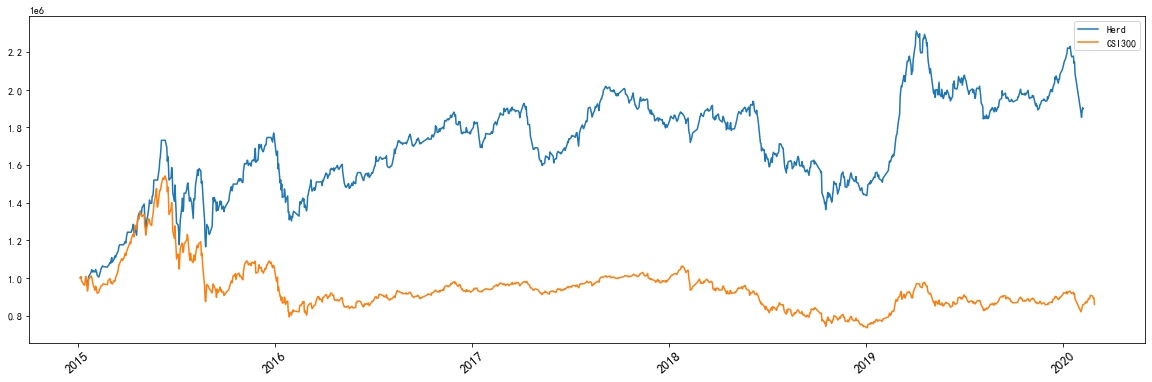

In [2]:
stock_zh_index_daily_df = ak.stock_zh_index_daily(symbol="sh000001")
CSI300 = stock_zh_index_daily_df[(stock_zh_index_daily_df.index >= '2015-01-01') &\
                                 (stock_zh_index_daily_df.index <= '2020-03-01')]['close']
CSI300.index = pd.to_datetime(CSI300.index, format='%Y-%m-%d').date
output.index = pd.to_datetime(output.index, format='%Y-%m-%d').date
CSI300 = CSI300/CSI300[0]*1000000
performance = pd.concat([output, CSI300], axis=1)
performance.columns = ['Herd','CSI300']
performance.plot(figsize=(20,6))
plt.xticks(size='small',rotation=40,fontsize=13)
plt.show()

<AxesSubplot:>

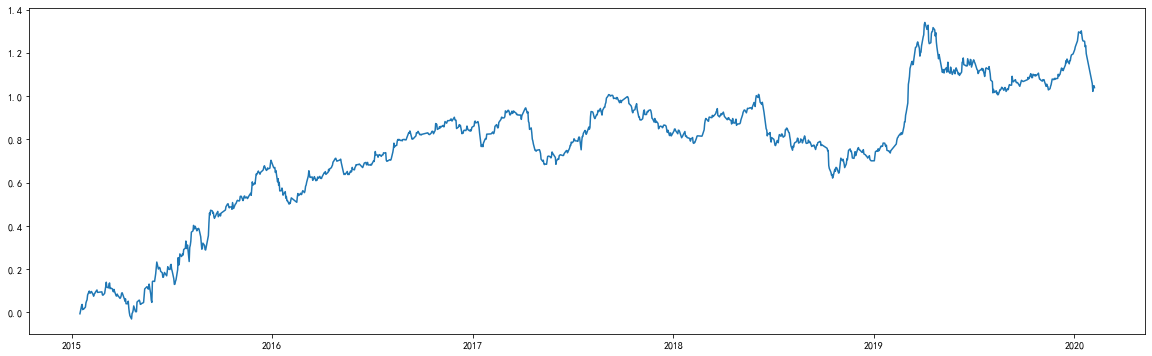

In [3]:
performance_1 = performance.dropna(axis=0, how='any')
alpha = (performance_1['Herd'] - performance_1['CSI300'])/1000000
alpha.plot(figsize=(20,6))

## Trade by Open

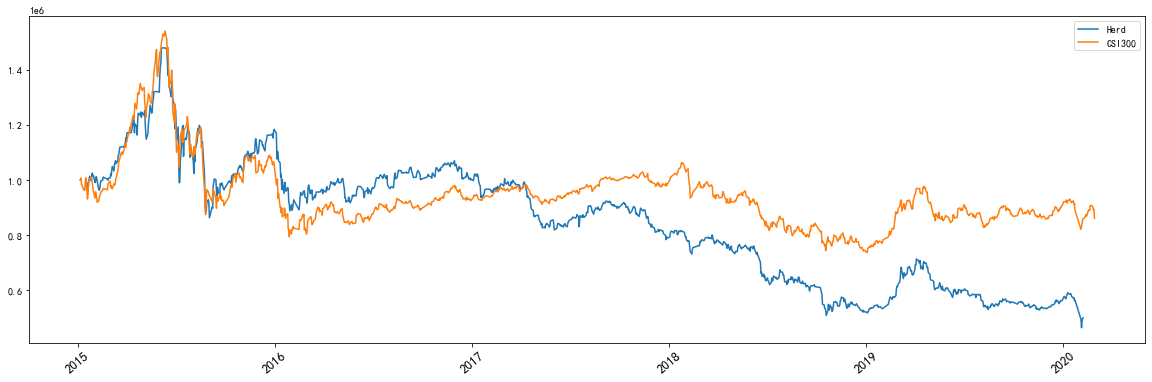

In [5]:
stock_zh_index_daily_df = ak.stock_zh_index_daily(symbol="sh000001")
CSI300 = stock_zh_index_daily_df[(stock_zh_index_daily_df.index >= '2015-01-01') &\
                                 (stock_zh_index_daily_df.index <= '2020-03-01')]['close']
CSI300.index = pd.to_datetime(CSI300.index, format='%Y-%m-%d').date
output.index = pd.to_datetime(output.index, format='%Y-%m-%d').date
CSI300 = CSI300/CSI300[0]*1000000
performance = pd.concat([output, CSI300], axis=1)
performance.columns = ['Herd','CSI300']
performance.plot(figsize=(20,6))
plt.xticks(size='small',rotation=40,fontsize=13)
plt.show()

<AxesSubplot:>

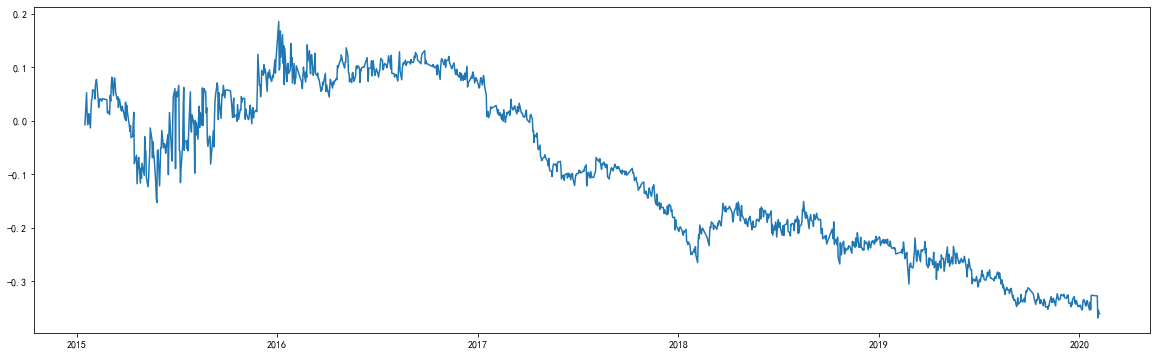

In [6]:
performance_1 = performance.dropna(axis=0, how='any')
alpha = (performance_1['Herd'] - performance_1['CSI300'])/1000000
alpha.plot(figsize=(20,6))